<a href="https://colab.research.google.com/github/shahriariit/COVID-19-Xray/blob/master/COVID19_XRay_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
 import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mimg
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,10)
from PIL import Image
from scipy import misc

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# DEEP LEARNING IMPORTS
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [49]:
import pandas as pd 
train = pd.read_csv('radiography.csv')
print(train.shape)
 

(657, 10001)


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from sklearn.utils import shuffle
train = shuffle(train)

In [0]:
#sliced for DNN 
X_train = train.iloc[:, 1:]
X_train  = X_train / 255.0
y_train  = train[['10001']]

In [0]:

 # Reshape and normalize training data
X = train.iloc[:, 1:]
X = X.values.reshape(train.shape[0],100, 100,1).astype( 'float32' )
X  = X / 255.0

y  = train[['10001']] 

In [31]:
 
 from keras.utils import np_utils
 train


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000,10001
201,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,46,55,49,85,82,88,84,98,110,118,122,120,119,119,113,104,111,106,116,119,185,219,199,192,...,219,221,222,220,220,219,219,217,224,228,228,230,230,230,229,232,228,227,230,237,235,237,236,233,228,228,232,240,230,223,222,231,240,216,206,196,189,85,78,0
320,0,0,0,15,32,47,57,67,70,70,69,108,117,118,125,109,107,100,67,75,78,77,73,71,61,48,30,21,0,0,1,12,59,88,115,175,203,185,190,201,...,208,211,208,214,207,201,206,207,202,205,210,210,204,207,203,201,180,194,196,185,183,182,177,164,147,152,163,177,156,148,137,117,100,145,117,35,0,0,52,1
278,68,69,64,63,57,56,55,49,39,25,0,0,0,0,0,0,6,46,60,71,85,99,108,131,144,142,144,154,152,182,197,178,192,191,206,212,240,240,230,211,...,150,154,164,174,173,154,157,150,154,156,157,179,163,153,141,110,97,100,105,114,113,110,114,120,125,116,110,93,73,49,36,0,0,7,8,9,12,11,14,1
286,43,57,69,85,88,87,87,84,86,111,115,104,107,115,78,87,86,83,72,122,130,137,133,131,131,130,128,118,134,152,163,165,167,177,192,193,193,213,216,212,...,195,184,187,185,178,179,180,176,163,178,169,161,165,165,158,160,146,145,148,159,158,148,155,143,142,123,117,101,76,66,54,0,0,1,5,7,6,8,8,1
173,4,4,4,4,4,4,4,4,3,3,3,2,1,1,11,17,25,25,26,32,34,38,42,47,53,51,55,61,65,73,72,80,80,79,82,105,112,130,132,134,...,242,243,242,242,241,240,243,242,241,241,240,240,240,238,238,236,236,235,232,229,226,229,227,229,218,211,203,198,184,175,170,156,131,120,85,44,4,7,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,101,103,115,115,194,175,177,170,179,185,182,185,141,145,142,139,128,123,121,104,100,83,67,67,49,25,0,0,60,69,84,100,101,141,171,187,188,188,198,211,...,248,249,254,253,251,250,236,238,242,242,246,239,243,238,233,241,250,248,229,229,231,225,215,207,227,218,187,177,195,183,132,103,75,57,21,0,0,0,0,1
403,101,106,107,139,112,64,66,70,64,58,60,55,56,53,51,39,34,26,20,13,1,1,15,30,29,93,96,112,119,127,138,147,156,233,225,232,200,212,221,231,...,192,185,183,175,178,168,181,180,185,184,187,181,183,180,180,181,182,173,177,183,177,191,182,182,186,181,174,174,161,160,107,187,122,54,21,0,0,0,0,1
347,29,27,23,19,57,64,72,85,87,95,99,103,104,105,104,120,136,127,129,166,95,80,119,145,147,148,148,141,137,141,135,153,166,215,184,187,217,153,174,144,...,198,175,161,154,163,162,165,175,161,177,178,139,125,130,124,112,105,101,109,132,126,126,120,139,173,145,148,136,91,64,28,3,10,14,12,11,5,51,115,1
435,0,0,7,25,30,27,110,74,70,75,76,90,85,27,45,39,41,36,36,34,32,30,14,0,0,0,0,9,0,54,83,86,95,97,110,127,125,133,135,137,...,188,188,183,176,178,172,163,149,144,143,128,137,144,139,144,154,151,146,149,157,138,142,142,126,126,128,115,93,102,98,67,22,0,0,0,0,0,0,0,1


In [52]:

from keras.utils import to_categorical
y = to_categorical(y)
y_train = to_categorical(y_train)
y.shape

(657, 3, 2)

In [0]:
def cnn_model(size, num_cnn_layers):
    NUM_FILTERS = 32
    KERNEL = (3, 3)
    #MIN_NEURONS = 20
    MAX_NEURONS = 120
    
    model = Sequential()
    
    for i in range(1, num_cnn_layers+1):
        if i == 1:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, input_shape=size, activation='relu', padding='same'))
        else:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, activation='relu', padding='same'))
  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(int(MAX_NEURONS), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(int(MAX_NEURONS/2), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #print(model.summary())
    
    return model

In [0]:
 IMAGE_SIZE = (100, 100, 1)
 model = cnn_model(IMAGE_SIZE, 2)

In [35]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 160000)            0         
_________________________________________________________________
dense_58 (Dense)             (None, 120)               19200120  
_________________________________________________________________
dropout_20 (Dropout)         (None, 120)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 60)              

In [0]:
#set early stopping criteria
avg_train_accuracy = []
avg_train_loss=[]
avg_validation_accuracy=[]
avg_validation_loss=[]
pat = 3 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
i=-1
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = cnn_model(IMAGE_SIZE, 2) 
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)
    
    avg_train_accuracy.append((results.history['accuracy'][-1])*100)
    avg_train_loss.append((results.history['loss'][-1])*100)
    avg_validation_accuracy.append((results.history['val_accuracy'][-1])*100)
    avg_validation_loss.append((results.history['val_loss'][-1])*100)
    print('Covid19 Train acc: {}'.format(np.round((results.history['accuracy'][-1])*100)))  
    
    print("Val Score: ", model.evaluate(val_x, val_y)) 
    return results 

In [37]:
n_folds= 10
epochs= 50
batch_size= 32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X, y, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Train on 531 samples, validate on 60 samples
Epoch 1/50
531/531 [==============================] - 22s 41ms/step - loss: 1.1951 - accuracy: 0.4991 - val_loss: 0.7331 - val_accuracy: 0.8333

Epoch 00001: val_loss improved from inf to 0.73313, saving model to fas_mnist_1.h5
Epoch 2/50
531/531 [==============================] - 22s 41ms/step - loss: 0.5235 - accuracy: 0.8098 - val_loss: 0.6282 - val_accuracy: 0.6000

Epoch 00002: val_loss improved from 0.73313 to 0.62822, saving model to fas_mnist_1.h5
Epoch 3/50
531/531 [==============================] - 21s 40ms/step - loss: 0.3030 - accuracy: 0.8757 - val_loss: 0.3180 - val_accuracy: 0.9000

Epoch 00003: val_loss improved from 0.62822 to 0.31796, saving model to fas_mnist_1.h5
Epoch 4/50
531/531 [==============================] - 21s 40ms/step - loss: 0.2221 - accuracy: 0.9209 - val_loss: 0.4422 - val_accuracy: 0.8500

Epoch 00004: val_loss did not improve from 0.31796
Epoch 5/50
531/531 [==========================

In [43]:
avg_acc = np.mean(avg_train_accuracy)
avg_loss = np.mean(avg_train_loss)
avg_val_acc = np.mean(avg_validation_accuracy)
avg_val_loss = np.mean(avg_validation_loss) 
print(avg_acc)
print(avg_loss)
print(avg_val_acc)
print(avg_val_loss)

99.34086561203003
2.2300383335688454
92.8333330154419
24.061067420989275


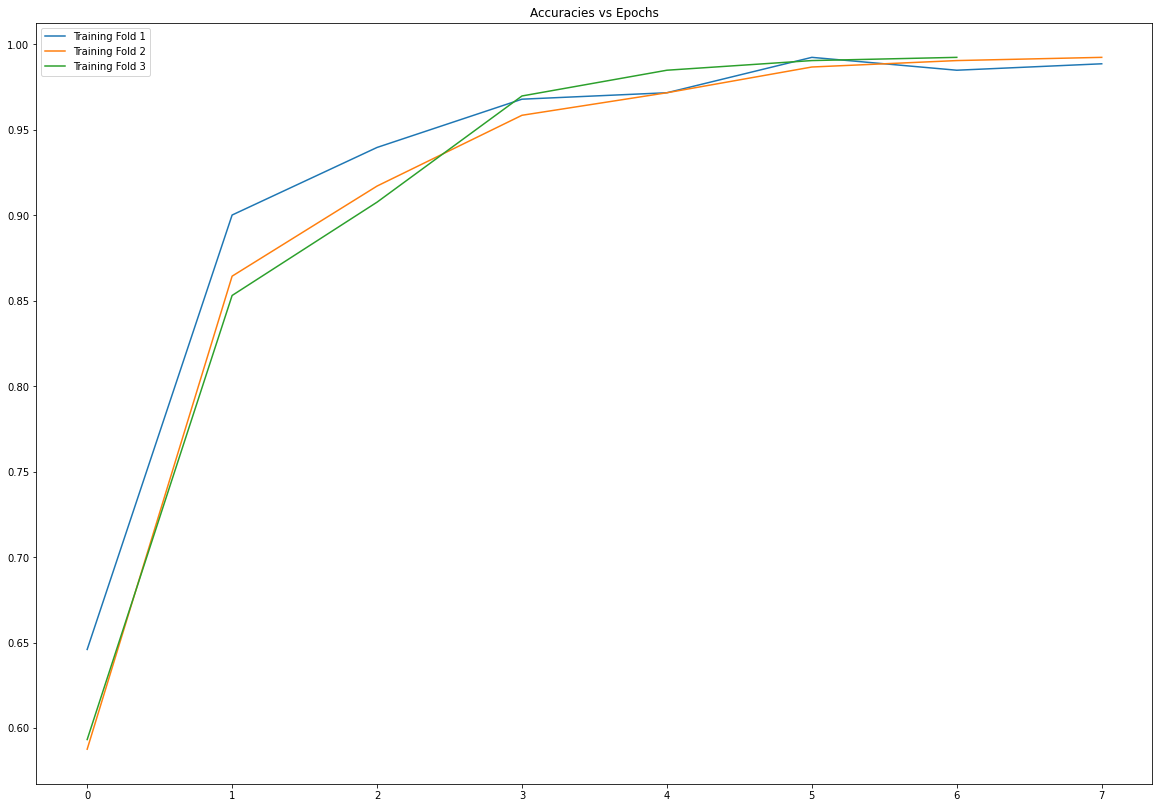

In [38]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')

plt.legend()
plt.show()

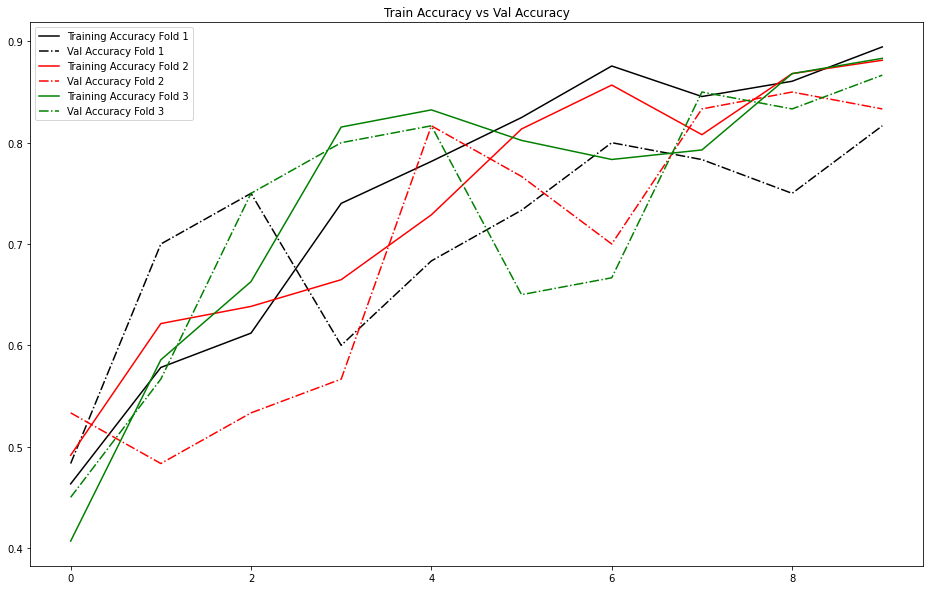

In [30]:
plt.title('Train Accuracy vs Val Accuracy')
 
plt.plot(model_history[0].history['accuracy'], label='Training Accuracy Fold 1',color='black' )
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Training Accuracy Fold 2',color='red')

plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Training Accuracy Fold 3',color='green')

plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")



plt.legend()
plt.show()

In [62]:
model = DNN()
model.summary()

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_154 (Dense)            (None, 512)               5120512   
_________________________________________________________________
dense_155 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_156 (Dense)            (None, 3)                 1539      
Total params: 5,384,707
Trainable params: 5,384,707
Non-trainable params: 0
_________________________________________________________________


In [0]:
def DNN():
  np.random.seed(1)
  model =  Sequential()
  model.add(Dense(units=512, input_dim=10000,
    activation='relu'))
  model.add(Dense(units=512,
    activation='relu'))
  model.add(Dense(units=3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
#set early stopping criteria
avg_train_accuracy = []
avg_train_loss=[]
avg_validation_accuracy=[]
avg_validation_loss=[]
pat = 3 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=20, BATCH_SIZE=128):
    model = None
    model = DNN() 
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    avg_train_accuracy.append((results.history['accuracy'][-1])*100)
    avg_train_loss.append((results.history['loss'][-1])*100)
    avg_validation_accuracy.append((results.history['val_accuracy'][-1])*100)
    avg_validation_loss.append((results.history['val_loss'][-1])*100)
    print('Covid19 Train acc: {}'.format(np.round((results.history['accuracy'][-1])*100)))  
    model.load_weights('fas_mnist_1.h5')
     
    print("Val Score: ", model.evaluate(val_x, val_y)) 
    return results 

In [76]:
n_folds= 10
epochs= 50
batch_size= 32

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, y_train, test_size=0.1, 
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n") 

Training on Fold:  1
Train on 531 samples, validate on 60 samples
Epoch 1/50
531/531 [==============================] - 1s 2ms/step - loss: 4.7369 - accuracy: 0.4896 - val_loss: 1.1893 - val_accuracy: 0.4833

Epoch 00001: val_loss improved from inf to 1.18930, saving model to fas_mnist_1.h5
Epoch 2/50
531/531 [==============================] - 1s 2ms/step - loss: 0.8657 - accuracy: 0.6573 - val_loss: 0.8127 - val_accuracy: 0.5500

Epoch 00002: val_loss improved from 1.18930 to 0.81270, saving model to fas_mnist_1.h5
Epoch 3/50
531/531 [==============================] - 1s 2ms/step - loss: 0.6345 - accuracy: 0.6949 - val_loss: 0.5482 - val_accuracy: 0.7667

Epoch 00003: val_loss improved from 0.81270 to 0.54819, saving model to fas_mnist_1.h5
Epoch 4/50
531/531 [==============================] - 1s 2ms/step - loss: 0.4996 - accuracy: 0.8154 - val_loss: 0.5603 - val_accuracy: 0.7667

Epoch 00004: val_loss did not improve from 0.54819
Epoch 5/50
531/531 [==============================] - 

In [77]:
avg_acc = np.mean(avg_train_accuracy)
avg_loss = np.mean(avg_train_loss)
avg_val_acc = np.mean(avg_validation_accuracy)
avg_val_loss = np.mean(avg_validation_loss) 
print(avg_acc)
print(avg_loss)
print(avg_val_acc)
print(avg_val_loss)

88.68173241615295
27.86324034765952
84.8333340883255
44.69115626811981


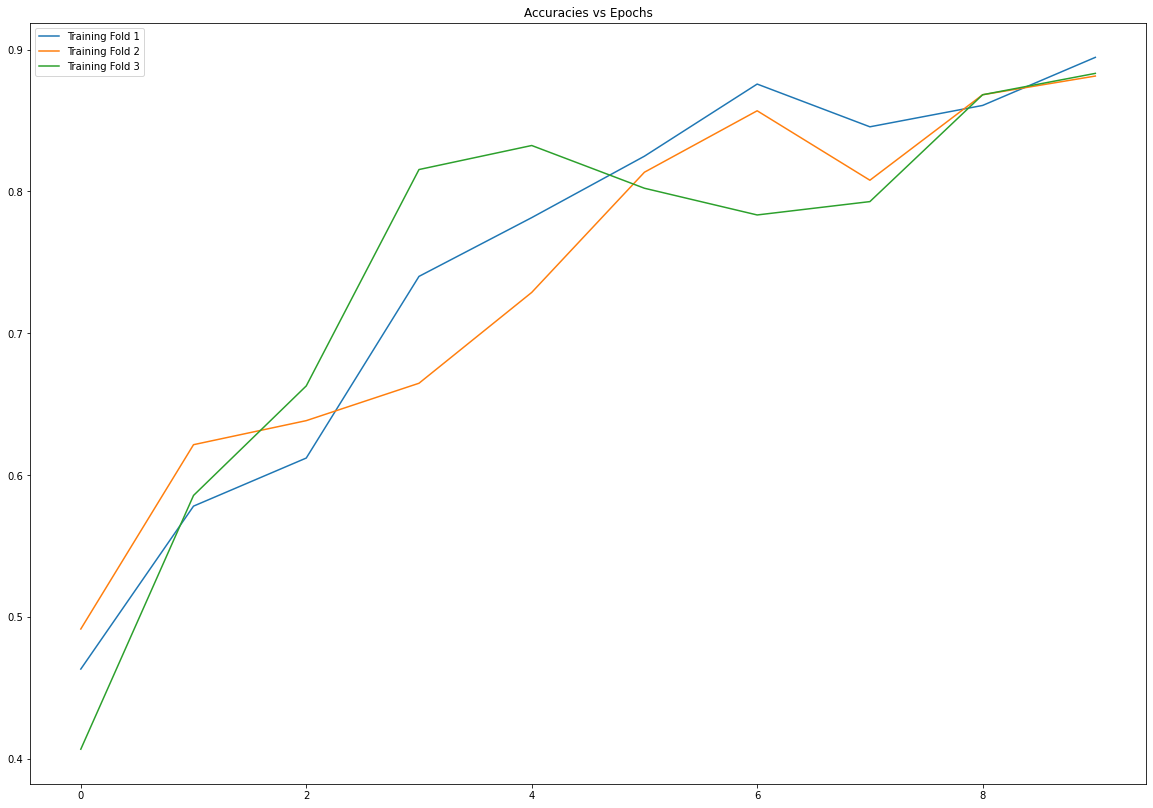

In [27]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')

plt.legend()
plt.show()

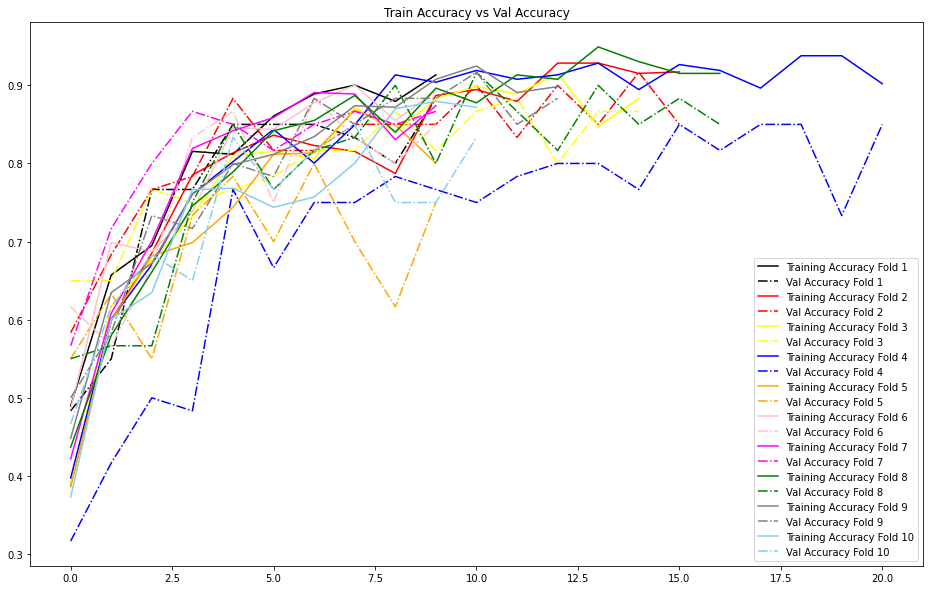

In [79]:
plt.title('Train Accuracy vs Val Accuracy')
 
plt.plot(model_history[0].history['accuracy'], label='Training Accuracy Fold 1',color='black' )
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Training Accuracy Fold 2',color='red')

plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Training Accuracy Fold 3',color='yellow')

plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='yellow', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Training Accuracy Fold 4',color='blue')

plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Training Accuracy Fold 5',color='orange')

plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")
plt.plot(model_history[5].history['accuracy'], label='Training Accuracy Fold 6',color='pink')

plt.plot(model_history[5].history['val_accuracy'], label='Val Accuracy Fold 6', color='pink', linestyle = "dashdot")
plt.plot(model_history[6].history['accuracy'], label='Training Accuracy Fold 7',color='magenta')

plt.plot(model_history[6].history['val_accuracy'], label='Val Accuracy Fold 7', color='magenta', linestyle = "dashdot")
plt.plot(model_history[7].history['accuracy'], label='Training Accuracy Fold 8',color='green')

plt.plot(model_history[7].history['val_accuracy'], label='Val Accuracy Fold 8', color='green', linestyle = "dashdot")
plt.plot(model_history[8].history['accuracy'], label='Training Accuracy Fold 9',color='gray')

plt.plot(model_history[8].history['val_accuracy'], label='Val Accuracy Fold 9', color='gray', linestyle = "dashdot")
plt.plot(model_history[9].history['accuracy'], label='Training Accuracy Fold 10',color='skyblue')
plt.plot(model_history[9].history['val_accuracy'], label='Val Accuracy Fold 10', color='skyblue', linestyle = "dashdot")



plt.legend()
plt.show()

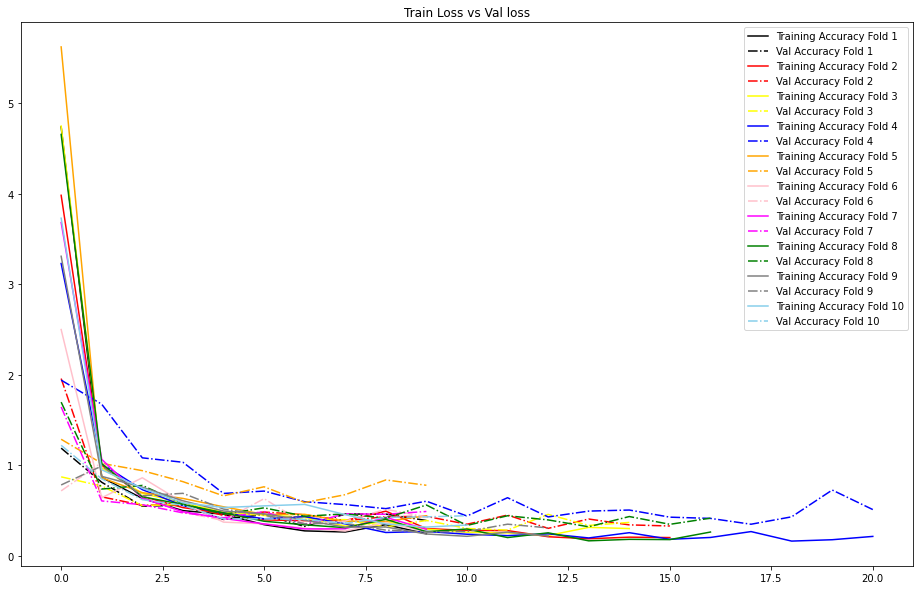

In [80]:
plt.title('Train Loss vs Val loss')
 
plt.plot(model_history[0].history['loss'], label='Training Accuracy Fold 1',color='black' )
plt.plot(model_history[0].history['val_loss'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['loss'], label='Training Accuracy Fold 2',color='red')

plt.plot(model_history[1].history['val_loss'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['loss'], label='Training Accuracy Fold 3',color='yellow')

plt.plot(model_history[2].history['val_loss'], label='Val Accuracy Fold 3', color='yellow', linestyle = "dashdot")
plt.plot(model_history[3].history['loss'], label='Training Accuracy Fold 4',color='blue')

plt.plot(model_history[3].history['val_loss'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['loss'], label='Training Accuracy Fold 5',color='orange')

plt.plot(model_history[4].history['val_loss'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")
plt.plot(model_history[5].history['loss'], label='Training Accuracy Fold 6',color='pink')

plt.plot(model_history[5].history['val_loss'], label='Val Accuracy Fold 6', color='pink', linestyle = "dashdot")
plt.plot(model_history[6].history['loss'], label='Training Accuracy Fold 7',color='magenta')

plt.plot(model_history[6].history['val_loss'], label='Val Accuracy Fold 7', color='magenta', linestyle = "dashdot")
plt.plot(model_history[7].history['loss'], label='Training Accuracy Fold 8',color='green')

plt.plot(model_history[7].history['val_loss'], label='Val Accuracy Fold 8', color='green', linestyle = "dashdot")
plt.plot(model_history[8].history['loss'], label='Training Accuracy Fold 9',color='gray')

plt.plot(model_history[8].history['val_loss'], label='Val Accuracy Fold 9', color='gray', linestyle = "dashdot")
plt.plot(model_history[9].history['loss'], label='Training Accuracy Fold 10',color='skyblue')
plt.plot(model_history[9].history['val_loss'], label='Val Accuracy Fold 10', color='skyblue', linestyle = "dashdot")



plt.legend()
plt.show()

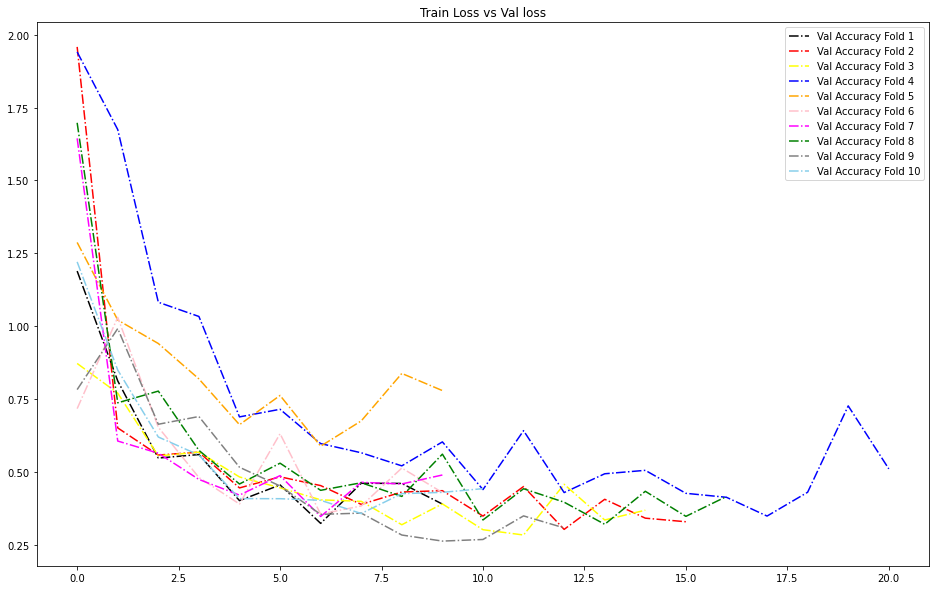

In [81]:
plt.title('Val loss')
 
plt.plot(model_history[0].history['val_loss'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")

plt.plot(model_history[1].history['val_loss'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")

plt.plot(model_history[2].history['val_loss'], label='Val Accuracy Fold 3', color='yellow', linestyle = "dashdot")

plt.plot(model_history[3].history['val_loss'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")

plt.plot(model_history[4].history['val_loss'], label='Val Accuracy Fold 5', color='orange', linestyle = "dashdot")
 
plt.plot(model_history[5].history['val_loss'], label='Val Accuracy Fold 6', color='pink', linestyle = "dashdot")
 
plt.plot(model_history[6].history['val_loss'], label='Val Accuracy Fold 7', color='magenta', linestyle = "dashdot")
 
plt.plot(model_history[7].history['val_loss'], label='Val Accuracy Fold 8', color='green', linestyle = "dashdot")
 
plt.plot(model_history[8].history['val_loss'], label='Val Accuracy Fold 9', color='gray', linestyle = "dashdot")
plt.plot(model_history[9].history['val_loss'], label='Val Accuracy Fold 10', color='skyblue', linestyle = "dashdot")



plt.legend()
plt.show()